<a href="https://colab.research.google.com/github/cws7777/AI_Expert_Lecture_Files/blob/main/Lab1_2_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Classification Example

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# PyTorch nn.Module
* 엄격한 객체지향(object-oriented)설계를 따라 확장 및 재사용이 class를 통해 torch.nn.Module 상속
* `__init__()` : 사용될 submodule들과 함수들을 정의
* `forward()` : 입력에 대한 output 계산, 이후 output에 직접 `backward()`를 불러 backpropagation 수행

In [2]:
class Classifier(nn.Module):
    def __init__(self, activation=None):
        super(Classifier, self).__init__()
        self.a = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
        self.b = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
        self.c = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
        if activation is not None:
            self.activate = activation
        else:
            self.activate = torch.sigmoid

    def forward(self, x):
        return self.activate(self.a * x[:,0] + self.b * x[:,1] - self.c).unsqueeze(-1)

In [3]:
class DataGenerator(Dataset):
    def __init__(self, type_, length, std=0.08):
        self.length = length
        if type_ == 'and':
            self.val_l = [0, 0, 0, 1]
        elif type_ == 'or':
            self.val_l = [0, 1, 1, 1]
        elif type_ == 'xor':
            self.val_l = [0, 1, 1, 0]
        else:
            self.val_l = [0, 0, 0, 0]

        self.dataset = []
        for i in range(length):
            x = np.random.normal(i%2, std)      #0,1,0,1,0,1,0,1,...
            y = np.random.normal((i//2)%2, std) #0,0,1,1,0,0,1,1,...
            val = self.val_l[i%4]
            self.dataset.append((x, y, val))

    def get_dataset(self):
        return self.dataset

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x, y, val = self.dataset[idx]
        return (torch.Tensor([x, y]), torch.Tensor([val]))

In [4]:
DATASET = DataGenerator('and', 1000)
lr = 0.01 # learning rate
batch_size = 20
num_epochs = 30
num_workers = 4

params = {
    'batch_size' : batch_size,
    'shuffle' : True,
    'num_workers' : num_workers
}

dataloader = DataLoader(DATASET, **params)
model = Classifier().cuda()
optimizer = Adam(model.parameters(), lr=lr)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


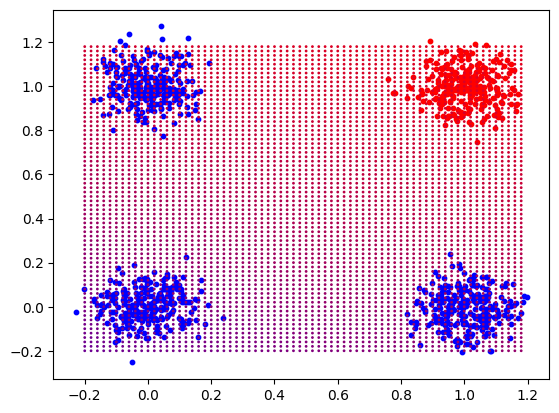

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loss : 0.25989
Loss : 0.18835
Loss : 0.16170
Loss : 0.14196
Loss : 0.12646
Loss : 0.11371
Loss : 0.10309
Loss : 0.09400
Loss : 0.08623
Loss : 0.07931


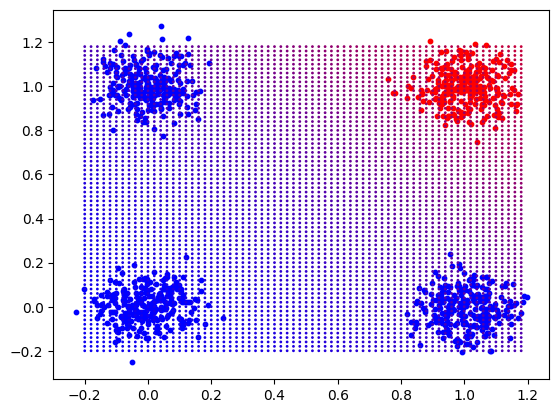

Loss : 0.07352
Loss : 0.06798
Loss : 0.06325
Loss : 0.05886
Loss : 0.05494
Loss : 0.05143
Loss : 0.04819
Loss : 0.04526
Loss : 0.04255
Loss : 0.04008


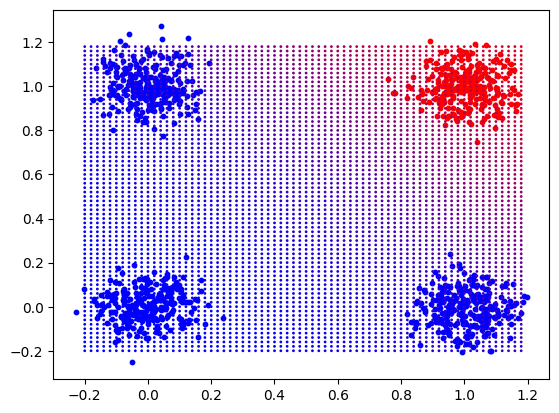

Loss : 0.03783
Loss : 0.03575
Loss : 0.03384
Loss : 0.03202
Loss : 0.03035
Loss : 0.02876
Loss : 0.02731
Loss : 0.02599
Loss : 0.02477
Loss : 0.02358


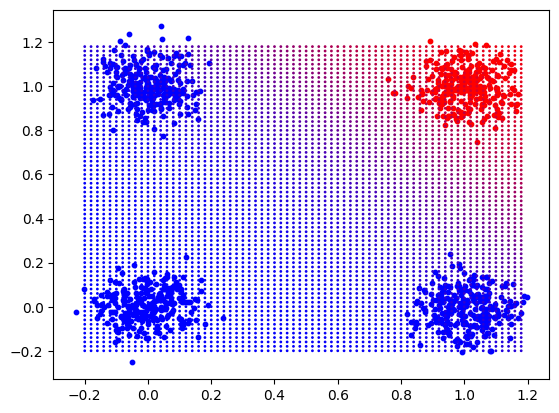

In [5]:
def show(model):
    for item in DATASET.get_dataset():
        x, y, val = item
        if val == 1:
            plt.scatter(x, y, c='red', s=10)
        else:
            plt.scatter(x, y, c='blue', s=10)
    t = torch.arange(70,dtype=torch.float32)*0.02-0.2
    x = t.unsqueeze(0).repeat(70,1).unsqueeze(-1)
    y = t.unsqueeze(1).repeat(1,70).unsqueeze(-1)
    data = torch.cat((x,y),-1).view(-1,2)
    with torch.no_grad():
        val = (model(data.cuda())).cpu()
    colors = torch.cat((val,torch.zeros_like(val),1-val),-1).numpy()
    plt.scatter(data.numpy()[:,0],data.numpy()[:,1], c=colors, s=1)
    plt.show()

show(model)

for epoch in range(num_epochs):
    total_loss = 0
    for x, val in dataloader:
        x = x.cuda()
        val = val.cuda()
        optimizer.zero_grad()
        val_ =  model(x)
        # loss 계산
        loss = torch.sum(torch.pow(val - val_, 2))
        # gradient 계산
        loss.backward()
        # update 적용
        optimizer.step()
        total_loss += loss.item()
    print("Loss : {:.5f}".format(total_loss / len(DATASET)))
    if epoch % 10  == 9:
        model.eval()
        show(model)
        model.train()